In [27]:
import json
import os
import requests
import warnings
from urllib.request import urlretrieve
import scanpy as sc
import anndata
import pandas as pd
import anndata as ad
import re
import scvi
import pickle
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import numpy as np
import scipy.sparse as sp
# import the packages needed

In [28]:
# jax set up

import os
os.environ.get("LD_LIBRARY_PATH", "")
print("\n".join(os.environ.get("LD_LIBRARY_PATH","").split(":")))

import subprocess, textwrap
print(subprocess.getoutput("hostname"))
print(subprocess.getoutput("nvidia-smi -L"))

import sys
print(sys.executable)

import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U "jax[cuda12]"
# or 13

import jax
print(jax.default_backend())
print(jax.devices())


gl0007.arc-ts.umich.edu
/bin/sh: nvidia-smi: command not found
/sw/pkgs/arc/python3.10-anaconda/2023.03/bin/python
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.0 MB/s  0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.3
    Uninstalling pip-25.3:
      Successfully uninstalled pip-25.3
Defaulting to user installation because normal site-packages is not writeable


ERROR:2026-02-19 16:24:06,276:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/wruopeng/.local/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/wruopeng/.local/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 324, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/wruopeng/.local/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 281, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JAX was unable to load the CUDA libraries.


cpu
[CpuDevice(id=0)]


In [29]:
KPMP_SN_raw=sc.read('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/kpmp-sn-raw-rnaseq.h5ad')
HuBMAP_LK_raw=sc.read('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/LK_raw_updated_2025_june.h5ad')
HuBMAP_RK_raw=sc.read('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/RK_raw_updated_2025_june.h5ad')

In [30]:
list(KPMP_SN_raw.obs['cell_type'].unique())

['kidney interstitial alternatively activated macrophage',
 'kidney distal convoluted tubule epithelial cell',
 'epithelial cell of proximal tubule',
 'T cell',
 'kidney loop of Henle thick ascending limb epithelial cell',
 'kidney collecting duct intercalated cell',
 'kidney interstitial fibroblast',
 'kidney connecting tubule epithelial cell',
 'kidney collecting duct principal cell',
 'endothelial cell',
 'B cell',
 'mature NK T cell',
 'mononuclear phagocyte',
 'podocyte',
 'parietal epithelial cell',
 'mast cell',
 'plasmacytoid dendritic cell, human',
 'plasma cell',
 'non-classical monocyte',
 'conventional dendritic cell',
 'kidney loop of Henle thin descending limb epithelial cell',
 'renal interstitial pericyte',
 'kidney loop of Henle thin ascending limb epithelial cell',
 'neutrophil',
 'papillary tips cell',
 'neural cell']

In [31]:
def filter_to_dataset_cell_types(
    adata,
    dataset_names,
    source_col='cell_type'
):
    # count before
    before = adata.n_obs

    # filter mask
    mask = adata.obs[source_col].isin(dataset_names)
    adata_filtered = adata[mask, :].copy()

    # report
    after = adata_filtered.n_obs
    print(
        f"Filtered to dataset cell types ({source_col}): "
        f"kept {after}/{before} cells ({before - after} removed)."
    )

    return adata_filtered

mapping = {
    # exact matches
    'B cell': 'B cell',
    'T cell': 'T cell',
    'conventional dendritic cell': 'conventional dendritic cell',
    'mast cell': 'mast cell',
    'mature NK T cell': 'mature NK T cell',
    'mononuclear phagocyte': 'mononuclear phagocyte',
    'neutrophil': 'neutrophil',
    'non-classical monocyte': 'non-classical monocyte',
    'papillary tips cell': 'papillary tips cell',
    'parietal epithelial cell': 'parietal epithelial cell',
    'plasma cell': 'plasma cell',
    'plasmacytoid dendritic cell, human': 'plasmacytoid dendritic cell, human',
    'podocyte': 'podocyte',
    'kidney interstitial fibroblast': 'kidney interstitial fibroblast',
    'renal interstitial pericyte': 'renal interstitial pericyte',
    # proximal tubule
    'epithelial cell of proximal tubule segment 1': 'epithelial cell of proximal tubule',
    'epithelial cell of proximal tubule segment 2': 'epithelial cell of proximal tubule',
    'epithelial cell of proximal tubule segment 3': 'epithelial cell of proximal tubule',
    # distal convoluted tubule
    'epithelial cell of early distal convoluted tubule': 'kidney distal convoluted tubule epithelial cell',
    'epithelial cell of late distal convoluted tubule': 'kidney distal convoluted tubule epithelial cell',
    # connecting tubule & collecting duct
    'kidney connecting tubule alpha-intercalated cell': 'kidney collecting duct intercalated cell',
    'kidney connecting tubule principal cell': 'kidney collecting duct principal cell',
    'kidney cortex collecting duct intercalated cell': 'kidney collecting duct intercalated cell',
    'kidney outer medulla collecting duct intercalated cell': 'kidney collecting duct intercalated cell',
    'kidney cortex collecting duct principal cell': 'kidney collecting duct principal cell',
    'kidney inner medulla collecting duct principal cell': 'kidney collecting duct principal cell',
    'kidney outer medulla collecting duct principal cell': 'kidney collecting duct principal cell',
    'kidney collecting duct intercalated cell': 'kidney collecting duct intercalated cell',
    'kidney collecting duct principal cell': 'kidney collecting duct principal cell',
    'kidney connecting tubule epithelial cell': 'kidney connecting tubule epithelial cell',
    # loop of Henle
    'kidney loop of Henle cortical thick ascending limb epithelial cell': 
        'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney loop of Henle medullary thick ascending limb epithelial cell': 
        'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney loop of Henle thick ascending limb epithelial cell': 
        'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney loop of Henle thin ascending limb epithelial cell': 
        'kidney loop of Henle thin ascending limb epithelial cell',
    'kidney loop of Henle short descending thin limb epithelial cell': 
        'kidney loop of Henle thin descending limb epithelial cell',
    'kidney loop of Henle long descending thin limb inner medulla epithelial cell': 
        'kidney loop of Henle thin descending limb epithelial cell',
    'kidney loop of Henle long descending thin limb outer medulla epithelial cell': 
        'kidney loop of Henle thin descending limb epithelial cell',
    # endothelial
    'endothelial cell': 'endothelial cell',
}
HuBMAP_LK_raw = filter_to_dataset_cell_types(HuBMAP_LK_raw, mapping, source_col='predicted_label')


HuBMAP_RK_raw = filter_to_dataset_cell_types(HuBMAP_RK_raw, mapping, source_col='predicted_label')

Filtered to dataset cell types (predicted_label): kept 1371041/1522897 cells (151856 removed).
Filtered to dataset cell types (predicted_label): kept 1673578/1803736 cells (130158 removed).


In [32]:
HuBMAP_RK_raw.var.index = HuBMAP_RK_raw.var.index.to_series().apply(lambda x: re.sub(r'\.\d+$', '', x))
HuBMAP_LK_raw.var.index = HuBMAP_LK_raw.var.index.to_series().apply(lambda x: re.sub(r'\.\d+$', '', x))

In [33]:
HuBMAP_LK_raw.var_names

Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167',
       ...
       'ENSG00000288635', 'ENSG00000288636', 'ENSG00000288637',
       'ENSG00000288638', 'ENSG00000288639', 'ENSG00000288640',
       'ENSG00000288642', 'ENSG00000288643', 'ENSG00000288644',
       'ENSG00000288645'],
      dtype='object', length=60286)

In [34]:
KPMP_SN_raw.var_names

Index(['ENSG00000121410', 'ENSG00000268895', 'ENSG00000148584',
       'ENSG00000175899', 'ENSG00000245105', 'ENSG00000166535',
       'ENSG00000256661', 'ENSG00000256904', 'ENSG00000184389',
       'ENSG00000128274',
       ...
       'ENSG00000086827', 'ENSG00000174442', 'ENSG00000122952',
       'ENSG00000198205', 'ENSG00000198455', 'ENSG00000070476',
       'ENSG00000203995', 'ENSG00000162378', 'ENSG00000159840',
       'ENSG00000074755'],
      dtype='object', name='index', length=36368)

In [35]:
# KPMP_SN_raw.var_names=KPMP_SN_raw.var['feature_name']
# HuBMAP_LK_raw.var_names=HuBMAP_LK_raw.var['hugo_symbol']
# HuBMAP_RK_raw.var_names=HuBMAP_RK_raw.var['hugo_symbol']

In [36]:
df = pd.read_csv("outer-cortex-datasets.csv")

# Extract IDs only from HuBMAP URLs
ids = []
for url in df["dataset"].astype(str):
    if "hubmapconsortium" in url:        # keep only HuBMAP
        entity_id = url.strip().split("/")[-1]
        ids.append(entity_id)

In [37]:
ids = (
    df.loc[df["dataset"].astype(str).str.contains("hubmapconsortium", na=False), "dataset"]
      .astype(str)
      .str.strip()
      .str.split("/")
      .str[-1]
      .tolist()
)

# subset: keep LK cells whose obs['dataset'] is in ids
adata_cortex_LK = HuBMAP_LK_raw[HuBMAP_LK_raw.obs["dataset"].isin(ids)].copy()
adata_cortex_RK = HuBMAP_RK_raw[HuBMAP_RK_raw.obs["dataset"].isin(ids)].copy()

In [38]:
KPMP_SN_raw

AnnData object with n_obs × n_vars = 304989 × 36368
    obs: 'library_id', 'nCount_RNA', 'nFeature_RNA', 'percent.er', 'percent.mt', 'subclass.l2', 'subclass.l1', 'class', 'experiment_id', 'suspension_type', 'assay_ontology_term_id', 'organism_ontology_term_id', 'donor_id', 'specimen', 'disease_category', 'disease_ontology_term_id', 'eGFR', 'diabetes_history', 'hypertension', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'region', 'percent.cortex', 'percent.medulla', 'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'Age_binned', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'

In [39]:
adata_cortex_LK
adata_cortex_RK

AnnData object with n_obs × n_vars = 1202609 × 60286
    obs: 'uuid', 'hubmap_id', 'age', 'sex', 'height', 'weight', 'bmi', 'cause_of_death', 'race', 'barcode', 'dataset', 'azimuth_label', 'azimuth_id', 'predicted_CLID', 'predicted_label', 'cl_match_type', 'prediction_score'
    var: 'hugo_symbol'
    uns: 'annotation_metadata', 'cell_type_counts', 'creation_date_time', 'datasets', 'uuid'
    obsm: 'X_spatial'

In [40]:
Hubmap_shared = {
    "cell_id": "cell_id", 
    "predicted_CLID": "cl_id",
    "predicted_label": "cell_type",
    "n_genes": "gene_count",
    "age": "age",
    "sex": "sex",
    "race": "race",
    "hubmap_id":"library_id"
}
HubMap_var_shared = {
    "hugo_symbol": "feature_name"
}

In [41]:
adata_cortex_LK.obs['as_id'] = "UBERON:0002113"
adata_cortex_LK.obs['disease'] = "normal"
adata_cortex_LK.obs['consortium'] = 'HuBMAP'
adata_cortex_RK.obs['as_id'] = "UBERON:0002113"
adata_cortex_RK.obs['disease'] = "normal"
adata_cortex_RK.obs['consortium'] = 'HuBMAP'

adata_cortex_LK.obs.rename(columns=Hubmap_shared, inplace=True)
adata_cortex_LK.var.rename(columns=HubMap_var_shared, inplace=True)
    
adata_cortex_RK.obs.rename(columns=Hubmap_shared, inplace=True)
adata_cortex_RK.var.rename(columns=HubMap_var_shared, inplace=True)

In [42]:
kpmp_subset=KPMP_SN_raw[KPMP_SN_raw.obs['tissue']== 'cortex of kidney']
kpmp_subset=kpmp_subset[kpmp_subset.obs['disease']== 'normal']

In [43]:
adata_cortex_LK.var_names

Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167',
       ...
       'ENSG00000288635', 'ENSG00000288636', 'ENSG00000288637',
       'ENSG00000288638', 'ENSG00000288639', 'ENSG00000288640',
       'ENSG00000288642', 'ENSG00000288643', 'ENSG00000288644',
       'ENSG00000288645'],
      dtype='object', length=60286)

In [44]:
KPMP_SN_raw.var_names

Index(['ENSG00000121410', 'ENSG00000268895', 'ENSG00000148584',
       'ENSG00000175899', 'ENSG00000245105', 'ENSG00000166535',
       'ENSG00000256661', 'ENSG00000256904', 'ENSG00000184389',
       'ENSG00000128274',
       ...
       'ENSG00000086827', 'ENSG00000174442', 'ENSG00000122952',
       'ENSG00000198205', 'ENSG00000198455', 'ENSG00000070476',
       'ENSG00000203995', 'ENSG00000162378', 'ENSG00000159840',
       'ENSG00000074755'],
      dtype='object', name='index', length=36368)

In [45]:

kpmp_subset

View of AnnData object with n_obs × n_vars = 70118 × 36368
    obs: 'library_id', 'nCount_RNA', 'nFeature_RNA', 'percent.er', 'percent.mt', 'subclass.l2', 'subclass.l1', 'class', 'experiment_id', 'suspension_type', 'assay_ontology_term_id', 'organism_ontology_term_id', 'donor_id', 'specimen', 'disease_category', 'disease_ontology_term_id', 'eGFR', 'diabetes_history', 'hypertension', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'region', 'percent.cortex', 'percent.medulla', 'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'Age_binned', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'

In [46]:
adata_cortex_LK

AnnData object with n_obs × n_vars = 296991 × 60286
    obs: 'uuid', 'library_id', 'age', 'sex', 'height', 'weight', 'bmi', 'cause_of_death', 'race', 'barcode', 'dataset', 'azimuth_label', 'azimuth_id', 'cl_id', 'cell_type', 'cl_match_type', 'prediction_score', 'as_id', 'disease', 'consortium'
    var: 'feature_name'
    uns: 'annotation_metadata', 'cell_type_counts', 'creation_date_time', 'datasets', 'uuid'
    obsm: 'X_spatial'

In [47]:
adata_cortex_RK

AnnData object with n_obs × n_vars = 1202609 × 60286
    obs: 'uuid', 'library_id', 'age', 'sex', 'height', 'weight', 'bmi', 'cause_of_death', 'race', 'barcode', 'dataset', 'azimuth_label', 'azimuth_id', 'cl_id', 'cell_type', 'cl_match_type', 'prediction_score', 'as_id', 'disease', 'consortium'
    var: 'feature_name'
    uns: 'annotation_metadata', 'cell_type_counts', 'creation_date_time', 'datasets', 'uuid'
    obsm: 'X_spatial'

In [48]:
common = kpmp_subset.var_names.intersection(adata_cortex_LK.var_names).intersection(adata_cortex_RK.var_names)

def get_sym(a):
    if "feature_name" in a.var: return a.var.loc[common, "feature_name"].astype("string")
    if "gene_name" in a.var:    return a.var.loc[common, "gene_name"].astype("string")
    return pd.Series(pd.NA, index=common, dtype="string")

sym = get_sym(kpmp_subset).fillna(get_sym(adata_cortex_LK)).fillna(get_sym(adata_cortex_RK))
# fallback to var_names if still NA
sym = sym.fillna(pd.Series(common.astype(str), index=common, dtype="string"))

# attach the unified gene_symbol to each dataset BEFORE concat
kpmp2 = kpmp_subset[:, common].copy()
lk2   = adata_cortex_LK[:, common].copy()
rk2   = adata_cortex_RK[:, common].copy()

for a in (kpmp2, lk2, rk2):
    a.var["gene_symbol"] = sym.loc[a.var_names].astype(str)

In [49]:
def Log_2_trans_data(adata):
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    if sp.issparse(adata.X):
        adata.X.data = np.log2(adata.X.data + 1.0)
    else:
        adata.X = np.log2(adata.X + 1.0)
    return adata

In [50]:
kpmp2=Log_2_trans_data(kpmp2)
lk2=Log_2_trans_data(lk2)
rk2=Log_2_trans_data(rk2)


In [51]:
adata_combined = ad.concat(
    [kpmp2, lk2, rk2],
    join="inner",
    label="batch_combine",
    keys=["KPMP","HuBMAP_LK","HuBMAP_RK"],
    merge="same",   # now it's identical across all three, so "same" is safe
)

In [52]:
adata_combined

AnnData object with n_obs × n_vars = 347863 × 28758
    obs: 'library_id', 'cell_type', 'disease', 'sex', 'n_genes', 'batch_combine'
    var: 'gene_symbol'

In [55]:

sc.tl.pca(adata_combined, n_comps=50)
adata_combined.obsm["Unintegrated"] = adata_combined.obsm["X_pca"]

In [56]:
adata_combined.write_h5ad('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/kpmp-hubmap-cortex-normal-log-2-transformation.h5ad')

In [ ]:
standard = {
    'kidney interstitial alternatively activated macrophage',
    'kidney distal convoluted tubule epithelial cell',
    'epithelial cell of proximal tubule',
    'T cell',
    'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney collecting duct intercalated cell',
    'kidney interstitial fibroblast',
    'kidney connecting tubule epithelial cell',
    'kidney collecting duct principal cell',
    'endothelial cell',
    'B cell',
    'mature NK T cell',
    'mononuclear phagocyte',
    'podocyte',
    'parietal epithelial cell',
    'mast cell',
    'plasmacytoid dendritic cell, human',
    'plasma cell',
    'non-classical monocyte',
    'conventional dendritic cell',
    'kidney loop of Henle thin descending limb epithelial cell',
    'renal interstitial pericyte',
    'kidney loop of Henle thin ascending limb epithelial cell',
    'neutrophil',
    'papillary tips cell',
    'neural cell',
}

mapping = {
    # PT segments -> PT
    'epithelial cell of proximal tubule segment 1': 'epithelial cell of proximal tubule',
    'epithelial cell of proximal tubule segment 2': 'epithelial cell of proximal tubule',
    'epithelial cell of proximal tubule segment 3': 'epithelial cell of proximal tubule',

    # DCT early/late -> DCT
    'epithelial cell of early distal convoluted tubule': 'kidney distal convoluted tubule epithelial cell',
    'epithelial cell of late distal convoluted tubule': 'kidney distal convoluted tubule epithelial cell',

    # TAL variants -> TAL
    'kidney loop of Henle cortical thick ascending limb epithelial cell':
        'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney loop of Henle medullary thick ascending limb epithelial cell':
        'kidney loop of Henle thick ascending limb epithelial cell',

    # Descending thin limb variants -> thin descending limb
    'kidney loop of Henle short descending thin limb epithelial cell':
        'kidney loop of Henle thin descending limb epithelial cell',
    'kidney loop of Henle long descending thin limb inner medulla epithelial cell':
        'kidney loop of Henle thin descending limb epithelial cell',
    'kidney loop of Henle long descending thin limb outer medulla epithelial cell':
        'kidney loop of Henle thin descending limb epithelial cell',

    # Collecting duct principal variants -> collecting duct principal
    'kidney cortex collecting duct principal cell': 'kidney collecting duct principal cell',
    'kidney outer medulla collecting duct principal cell': 'kidney collecting duct principal cell',
    'kidney inner medulla collecting duct principal cell': 'kidney collecting duct principal cell',

    # Collecting duct intercalated variants -> collecting duct intercalated
    'kidney cortex collecting duct intercalated cell': 'kidney collecting duct intercalated cell',
    'kidney outer medulla collecting duct intercalated cell': 'kidney collecting duct intercalated cell',
    'kidney connecting tubule alpha-intercalated cell': 'kidney collecting duct intercalated cell',  # if you prefer CD-IC
    # If you prefer CNT-IC instead, comment the line above and use:
    # 'kidney connecting tubule alpha-intercalated cell': 'kidney connecting tubule epithelial cell',

    # Connecting tubule principal -> connecting tubule epithelial
    'kidney connecting tubule principal cell': 'kidney connecting tubule epithelial cell',
}

ct = adata_combined.obs['cell_type'].astype(str)

ct2 = ct.replace(mapping)

ct2 = ct2.where(ct2.isin(standard), pd.NA)
adata_combined.obs['cell_type'] = pd.Categorical(ct2, categories=sorted(standard))

unmapped = sorted(set(ct) - set(ct[ct2.notna()]))
print("Unmapped original labels:", unmapped)

Unmapped original labels: []


In [58]:
list(adata_combined.obs['cell_type'].unique())

['kidney interstitial alternatively activated macrophage',
 'kidney distal convoluted tubule epithelial cell',
 'epithelial cell of proximal tubule',
 'T cell',
 'kidney loop of Henle thick ascending limb epithelial cell',
 'kidney collecting duct intercalated cell',
 'kidney interstitial fibroblast',
 'kidney connecting tubule epithelial cell',
 'kidney collecting duct principal cell',
 'endothelial cell',
 'B cell',
 'mature NK T cell',
 'mononuclear phagocyte',
 'podocyte',
 'parietal epithelial cell',
 'mast cell',
 'plasmacytoid dendritic cell, human',
 'plasma cell',
 'non-classical monocyte',
 'conventional dendritic cell',
 'kidney loop of Henle thin descending limb epithelial cell',
 'renal interstitial pericyte',
 'kidney loop of Henle thin ascending limb epithelial cell',
 'neutrophil',
 'papillary tips cell',
 'neural cell']

In [59]:
sc.external.pp.harmony_integrate(adata_combined, key=['batch_combine','library_id'], max_iter_harmony=500)

2026-02-19 16:32:16,242 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2026-02-19 16:32:43,264 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-02-19 16:32:45,162 - harmonypy - INFO - Iteration 1 of 500
2026-02-19 16:35:47,087 - harmonypy - INFO - Iteration 2 of 500
2026-02-19 16:38:49,688 - harmonypy - INFO - Iteration 3 of 500
2026-02-19 16:41:54,802 - harmonypy - INFO - Converged after 3 iterations


In [64]:
adata_combined

AnnData object with n_obs × n_vars = 347863 × 28758
    obs: 'library_id', 'cell_type', 'disease', 'sex', 'n_genes', 'batch_combine', 'leiden'
    var: 'gene_symbol'
    uns: 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'Unintegrated', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
sc.pp.neighbors(adata_combined, use_rep='X_pca_harmony')
sc.tl.leiden(adata_combined)
sc.tl.umap(adata_combined,min_dist=0.3)
adata_combined.obsm["X_umap"] = adata_combined.obsm[umap_key]
sc.pl.umap(
        adata_combined,
        title=f"UMAP using {key} embedding",
        save=f"Umap_{key}.png"
    )

/tmp/ipykernel_489407/1874894544.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined)


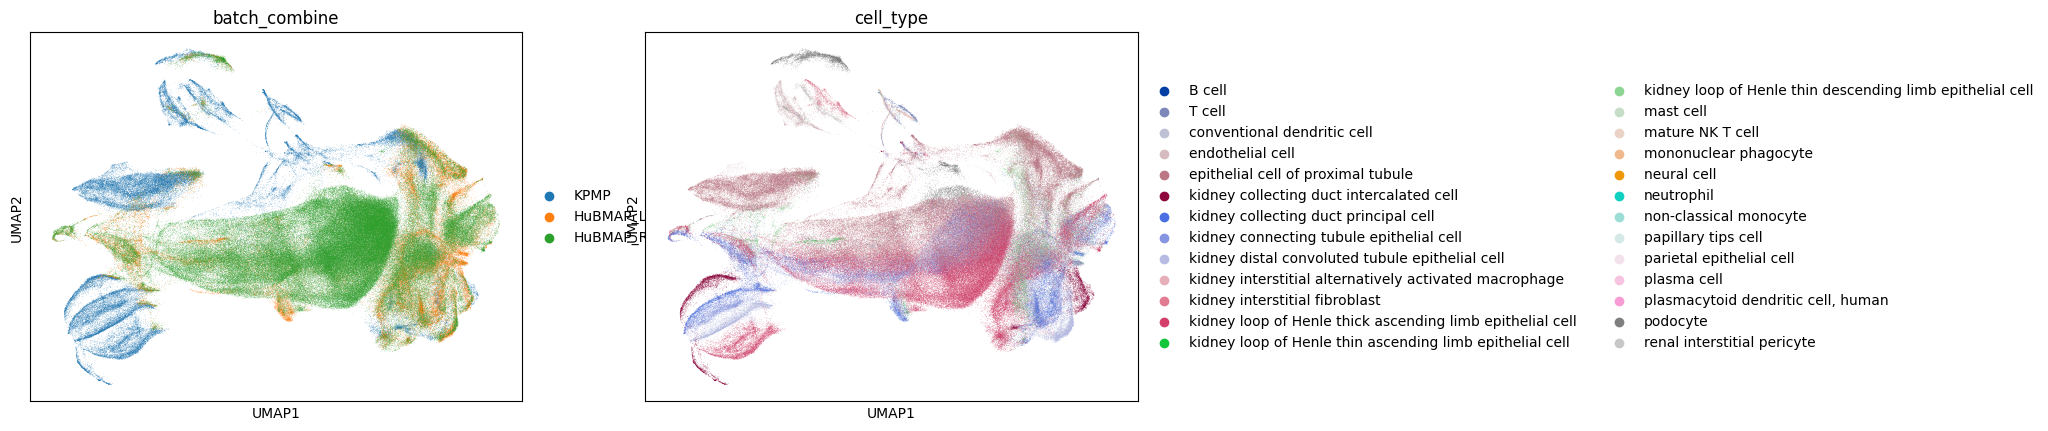

In [67]:
sc.pl.umap(
        adata_combined,color=['batch_combine','cell_type']
    )